# Macaque Analysis Notebook

**Abhay Katoch**

*Sunday, December 15th, 2024*

### To-Do List:
- [ ] Implement multiple runs for tSNE output.

### Importing Libraries

In [1]:
import os
import random
random.seed(634)

from pathlib import Path
data_directory = Path("/Users/abhay/Documents/School/Thesis/project/data/marmoset_data")

# libraries for dealing with numbers / data files
import numpy as np
import pandas as pd

# Libraries for plotting
from matplotlib import pyplot as plt

# Libraries for Stats
from statsmodels.stats.anova import AnovaRM
import scipy.stats as ss

# Custom code libraries for managing data
from functions.reduce_dimensions import smooth_columns, reduce_dim, calculate_jumps

### Loading fMRI Data

In [85]:
# Construct a list of directories, each of which contains all scans for a particular patient.
directories = sorted([directory for directory in os.listdir(data_directory) if not directory.startswith('.')])
conditions = ['Anaesthetized','Awake']

# Initialize a dictionary where each key are the directories mentioned above, and each value is the concatenated fMRI scans.
concatenated_scans = {directories[i]: np.zeros(shape = (7152, 116)) for i in range(len(directories))}

# For each directory, load every scan in the directory then concatenate the scans into the above-mentioned dictionary.
for directory in directories:
    scans = sorted([f for f in os.listdir(os.path.join(data_directory, directory)) if f.endswith('.tsv')])

    scans_list = []
    for scan in scans:
        filepath = os.path.join(data_directory, directory, scan)
        data = np.loadtxt(filepath, delimiter = "\t", skiprows = 1)
        scans_list.append(data)
    
    concatenated_scans[directory] = np.concatenate([scan for scan in scans_list], 0)

### Running tSNE & Plotting Results

In [12]:
# Initialize a dictionary where each key are the directories mentioned above, and each value is the tsne output.
tsne_output = {directories[i]: np.zeros(shape = (7152, 116)) for i in range(len(directories))}

for directory in directories:
    smoothed_data = smooth_columns(concatenated_scans[directory], 5)
    tsne_output[directory] = reduce_dim(smoothed_data)

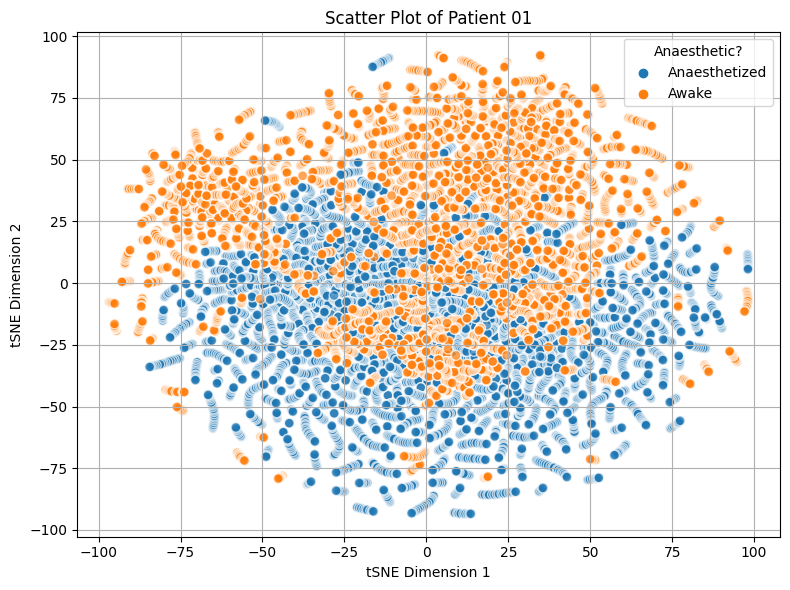

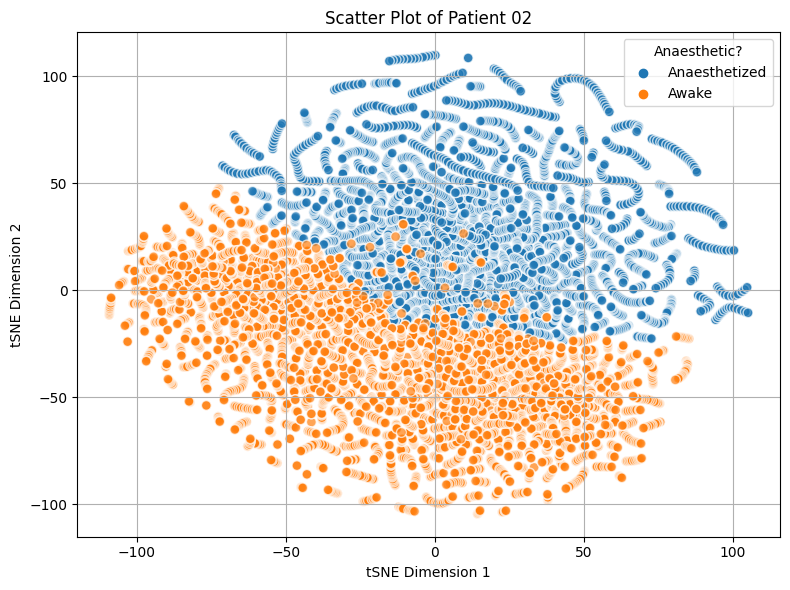

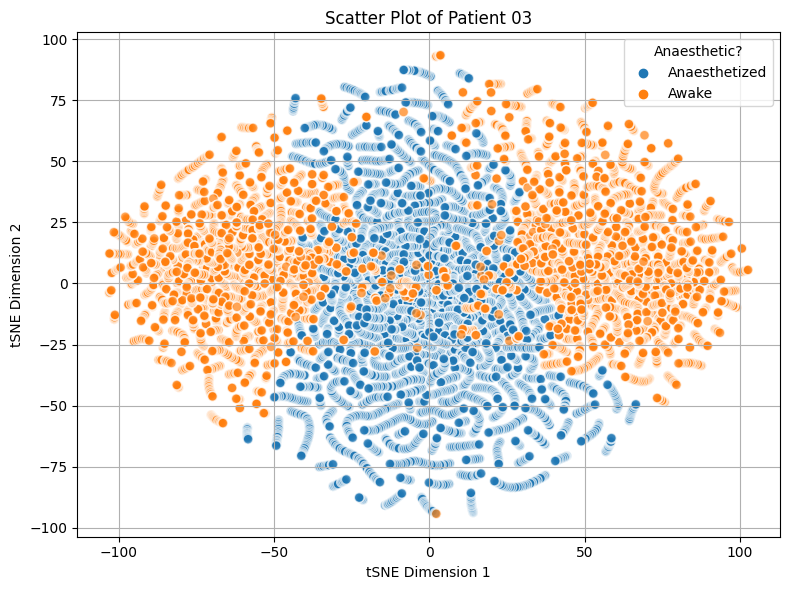

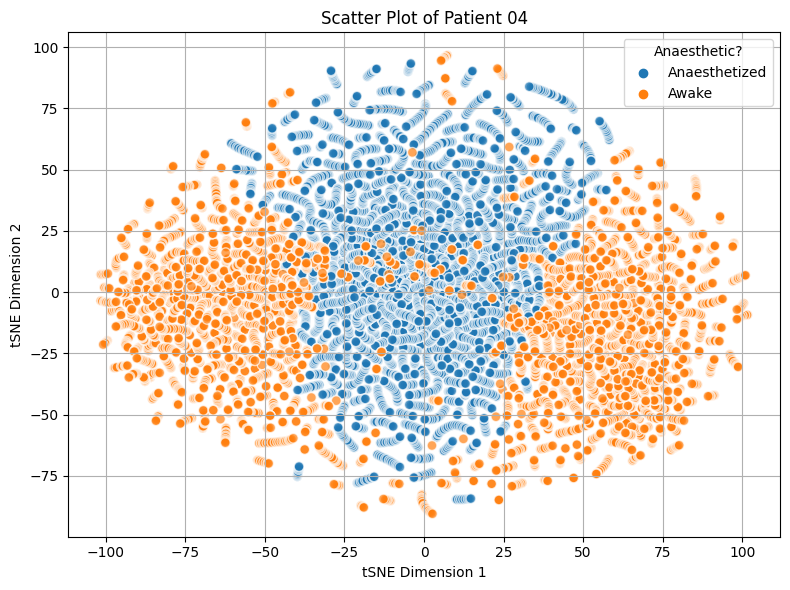

In [21]:
# For each patient, plot the concatenated tSNE output by anaesthetic dose. 
for directory in directories:
    x = tsne_output[directory][:, 0]
    y = tsne_output[directory][:, 1]
    
    plt.figure(figsize=(8, 6))
    # Create a colormap, where each timepoint is assigned to either the awake or anaesthetized group.
    colors = plt.cm.tab10(np.repeat(np.arange(len(x) // 3576), 3576))
    scatter = plt.scatter(x, y, c = colors, alpha = 0.7, edgecolors = 'w', s = 50)

    # Add Legend
    for i, label in enumerate(conditions):
        plt.scatter([], [], color=plt.cm.tab10(i), label=label)

    plt.legend(loc='upper right', title="Anaesthetic?")
    plt.title(f"Scatter Plot of Patient {directory}")
    plt.xlabel('tSNE Dimension 1')
    plt.ylabel('tSNE Dimension 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Calculating Mentation Rate

In [62]:
full_patients = [patient for patient in tsne_output if tsne_output[patient].shape[0] == 7152]
mentation_rate = pd.DataFrame(columns = ["Patient", "Scan", "Condition", "Rate"])

for patient in full_patients:
    split_data = np.array_split(tsne_output[patient], 12, axis=0)
    conditions_dataset = {f"{conditions[i >= 6]}_{i}": split_data[i] for i in range(12)}

    for condition in conditions_dataset:
        peaks, rate = calculate_jumps(conditions_dataset[condition], 2)
        group, scan = condition.split("_")

        mentation_rate.loc[len(mentation_rate)] = {"Patient": patient, "Scan": scan, "Condition": group, "Rate": rate}
    
mentation_rate

,Patient,Scan,Condition,Rate
0,01,0,Anaesthetized,2.969799
1,01,1,Anaesthetized,2.768456
2,01,2,Anaesthetized,2.919463
3,01,3,Anaesthetized,3.372483
4,01,4,Anaesthetized,2.869128
5,01,5,Anaesthetized,2.969799
6,01,6,Awake,3.523490
7,01,7,Awake,3.724832
8,01,8,Awake,3.825503
9,01,9,Awake,3.724832


### Running Wilcoxon Signed-Rank Test and Plotting Results

In [75]:
anaesthetized_samples = mentation_rate[mentation_rate["Condition"] == "Anaesthetized"]["Rate"]
awake_samples = mentation_rate[mentation_rate["Condition"] == "Awake"]["Rate"]

W_stat, p_value = ss.wilcoxon(anaesthetized_samples, awake_samples, alternative = "less")
print(f"Wilcoxon signed-rank test to see if anaesethetized samples are less than awake samples (μ < 0): W = {W_stat}, p = {p_value}")

Wilcoxon signed-rank test to see if anaesethetized samples are less than awake samples (μ < 0): W = 0.0, p = 5.960464477539063e-08


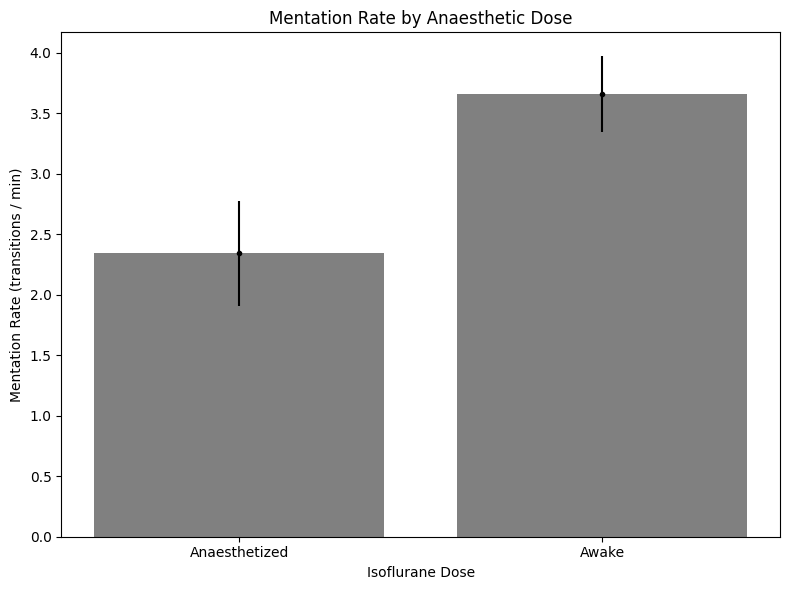

In [84]:
mean_rates = mentation_rate.groupby(by = "Condition")["Rate"].mean().values
std_rates = mentation_rate.groupby(by = "Condition")["Rate"].std().values

plt.figure(figsize=(8, 6))
plt.bar(conditions, mean_rates, color = "grey")
plt.errorbar(conditions, mean_rates, std_rates, fmt='.', color='black')
plt.title(f"Mentation Rate by Anaesthetic Dose")
plt.xlabel('Isoflurane Dose')
plt.ylabel('Mentation Rate (transitions / min)')
plt.tight_layout()
plt.show()